# Lecture 6: Training II

In [1]:
import datetime
now = datetime.datetime.now()
print("Version: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Version: 2020-02-06 17:37:22


# Stochastic gradient descent

## Problems with batch gradient descent

- Uses the entire training set to compute gradients at every step (slow when the training set is large).

- Full training set needs to be held in memory.

## Properties of stochastic gradient descent

- Uses a (random) single instance from the training set to compute gradients at each iteration (fast since very little data considered for each iteration).
- Only one instance of training data then needs to be held in memory.
- Less regular than batch gradient descent.
  - Helps to escape local minimia.
  - Ends up close to a minimum but continues to explore vacinity around minimum ("bounces" around).

## Simulated annealing

To mitigate issue of bouncing around minimum, can reduce learning rate as algorithm proceeds.

Called *simulated annealing* by analogy with annealing in metallurgy.

*Learning schedule* defines how learning rate chances over time.

- If learning rate reduces too quickly, may get stuck on local minimum or end up frozen half-way to minimum.
- If learning rate reduces too slowly, may jump around minimum for long time.

### Example learning schedule

Set learning rate $\alpha$ at iteration $t$ by
$$\alpha(t) = \frac{t_0}{t + t_1},$$

where $t_0$ and $t_1$ are parameters.

## Stochastic gradient descent example

In [2]:
# Common imports
import os
import numpy as np
np.random.seed(42) # To make this notebook's output stable across runs

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### Set up training data (repeating example from previous lecture)

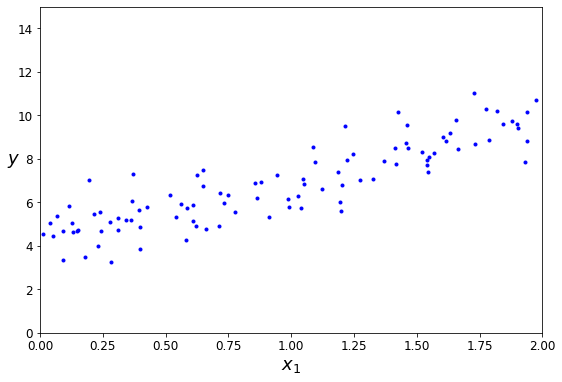

In [3]:
m = 100
X = 2 * np.random.rand(m, 1)
y = 4 + 3 * X + np.random.randn(m, 1)
plt.figure(figsize=(9,6))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15]);

### Add bias terms

In [4]:
X_b = np.c_[np.ones((m, 1)), X]         # add x0 = 1 to each instance
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance

### Solve by SGD with learning schedule

In [5]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

array([[4.21076011],
       [2.74856079]])

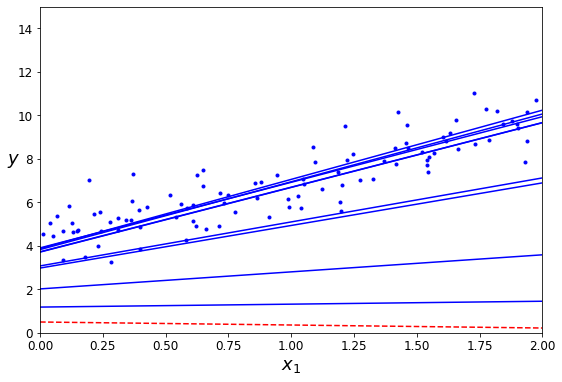

In [6]:
plt.figure(figsize=(9,6))
for epoch in range(n_epochs):  # how many times we used "ALL" of the training data (iter #1)
    for i in range(m): # training data instance (iter #2)
        
        # Plot current model
        if epoch == 0 and i < 10:                   
            y_predict = X_new_b.dot(theta)          
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        
        # SGD update (no consideration to actually consider ALL data, as we are samplng randomly)
        random_index = np.random.randint(m) # random sampling 
        xi = X_b[random_index:random_index+1] 
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        alpha = learning_schedule(epoch * m + i)        
        theta = theta - alpha * gradients
        theta_path_sgd.append(theta)                 

plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15]);
theta

Use only 50 passes over the data, compared to 1000 for batch gradient descent.

### Exercise: Solve using Scikit-Learn (without learning schedule)

Solve the above problem using Scikit-Learn, considering a learning rate of 0.1.  Display the intercept and slope of the fitted line.

In [7]:
from sklearn.linear_model import SGDRegressor as SGDR
sgd_reg = SGDR(max_iter=50, penalty=None, eta0=0.1, random_state=12)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([4.19123912]), array([2.76007016]))

# Mini-batch gradient descent


Use *mini-batches* of small random sets of instances of training data.

Trades off properties of batch GD and stochastic GD.

Can get a performance boost over SGD by exploiting hardware optimisation for matrix operations, particuarly for GPUs.

## Shuffling training data

First step is to randomly shuffle or reorder data-set since do not want to be sensitive to ordering of data (want mini-batch considered to be representative).

### Exercise: implement a mini-batch gradient descent algorithm to solve previous problem.

Hints: 
  - May want to start with stochastic GD implementation and adapt it. 
  - The numpy function [`np.random.permutation`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.permutation.html) may be useful.

This is just the latest from a single MB [[4.18223159]
 [2.79659366]]
This is mean of 5 latest batches [[4.18099323]
 [2.79959988]]


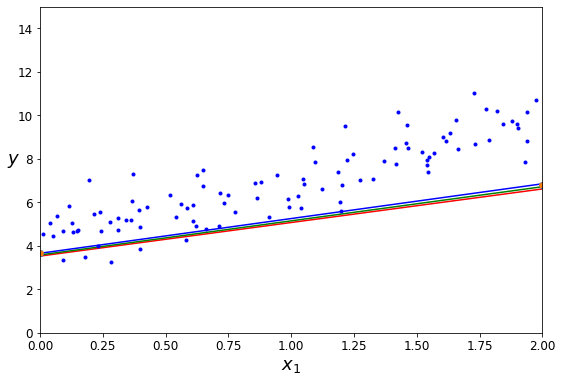

In [43]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 5, 50
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
# we have 5 minibatches print(len(X_b)/mb_size)
colors = ["r", "g", "b", "o", "p"]


plt.figure(figsize=(9,6))
for epoch in range(n_iterations):
   # MBGD update (shuffling data to consider ALL datay)
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    i_mb_count = 0
      #loop over MB
    for i in range(0, m, minibatch_size):
        t += 1 # update t for annealing 
        #pull out MB 
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)
        if (epoch==1):
            plt.plot( (0, 2), (theta[0][0],1*theta[1][0]+theta[0][0]), colors[i_mb_count] )
            i_mb_count+=1

plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15]);

print("This is just the latest from a single MB", theta)
print("This is mean of 5 latest batches", np.mean(theta_path_mgd[-6:-1], axis=0))

# Comparing gradient descent algorithms

## Repeat batch gradient descent from previous lecture

In [44]:
theta_path_bgd = []

def plot_gradient_descent(theta, alpha, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - alpha * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\alpha = {}$".format(alpha), fontsize=16)

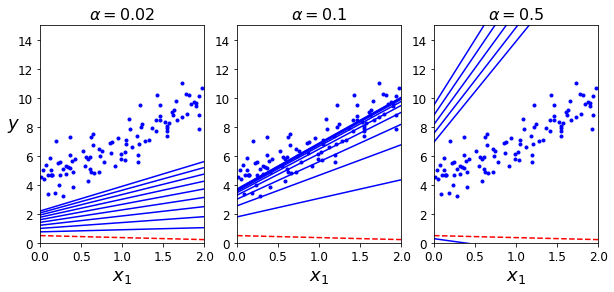

In [45]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, alpha=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, alpha=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, alpha=0.5)

## Convert lists to numpy arrays

In [46]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

## Algorithm trajectories

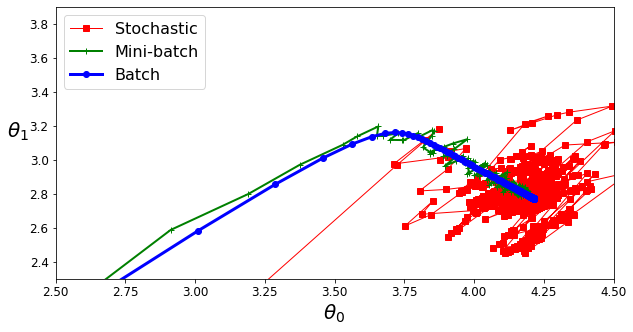

In [47]:
plt.figure(figsize=(10,5))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9]);